In [1]:
# Import packages
import findspark
findspark.init()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from pyspark.sql import SparkSession
import time
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import figure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/05 19:37:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://groupfourproject.s3.ca-central-1.amazonaws.com/bank_churners.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("bank_churners.csv"), sep=",", header=True, ignoreLeadingWhiteSpace=True)
df.show()


+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [4]:

pandas_df = df.toPandas()
pandas_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                              --------------  ----- 
 0   CLIENTNUM                                                                                                                           10127 non-null  object
 1   Attrition_Flag                                                                                                                      10127 non-null  object
 2   Customer_Age                                                                                                                        10127 non-null  object
 3   Gender                                                                                

In [5]:
pandas_df.select_dtypes(include="object").nunique()

CLIENTNUM                                                                                                                             10127
Attrition_Flag                                                                                                                            2
Customer_Age                                                                                                                             45
Gender                                                                                                                                    2
Dependent_count                                                                                                                           6
Education_Level                                                                                                                           7
Marital_Status                                                                                                                            4
Income_Category     

In [6]:
# drop columns 
bank_df = pandas_df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", "CLIENTNUM"], axis=1)

In [7]:
bank_df.describe().T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Customer_Age,10127,45,44,500
Gender,10127,2,F,5358
Dependent_count,10127,6,3,2732
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436
Months_on_book,10127,44,36,2463
Total_Relationship_Count,10127,6,3,2305


In [8]:
data = bank_df.copy()

In [9]:
def summary(data: pd.DataFrame, x: str):
    data[x] = pd.to_numeric(data[x], errors='coerce')
    
    data = data.dropna(subset=[x])
    
    # 5 point summary
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)

    summary_dict = {"Min": x_min, "Q1": Q1, "Q2": Q2, "Q3": Q3, "Max": x_max}
    summary_df = pd.DataFrame(data=summary_dict, index=["Value"])
    print(f"5 Point Summary of {x.capitalize()} Attribute:\n")
    print(tabulate(summary_df, headers="keys", tablefmt="psql"))

    # Plotting
    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(hspace=0.6)
    sns.set_palette("Pastel1")

    plt.subplot(221, frameon=True)
    ax1 = sns.histplot(data[x], kde=True, color="purple")
    ax1.axvline(np.mean(data[x]), color="purple", linestyle="--", label='Mean')
    ax1.axvline(np.median(data[x]), color="black", linestyle="-", label='Median')
    plt.title(f"{x.capitalize()} Density Distribution")
    plt.legend()

    plt.subplot(222, frameon=True)
    ax2 = sns.violinplot(x=data[x], palette="Accent")
    plt.title(f"{x.capitalize()} Violinplot")

    # Box plot
    plt.subplot(223, frameon=True)
    ax3 = sns.boxplot(x=data[x], palette="cool", width=0.7, linewidth=0.6, showmeans=True)
    plt.title(f"{x.capitalize()} Boxplot")

    # Cumulative density distribution
    plt.subplot(224, frameon=True)
    ax4 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f"{x.capitalize()} Cumulative Density Distribution")

    plt.show()

5 Point Summary of Customer_age Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    26 |   41 |   46 |   52 |    73 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


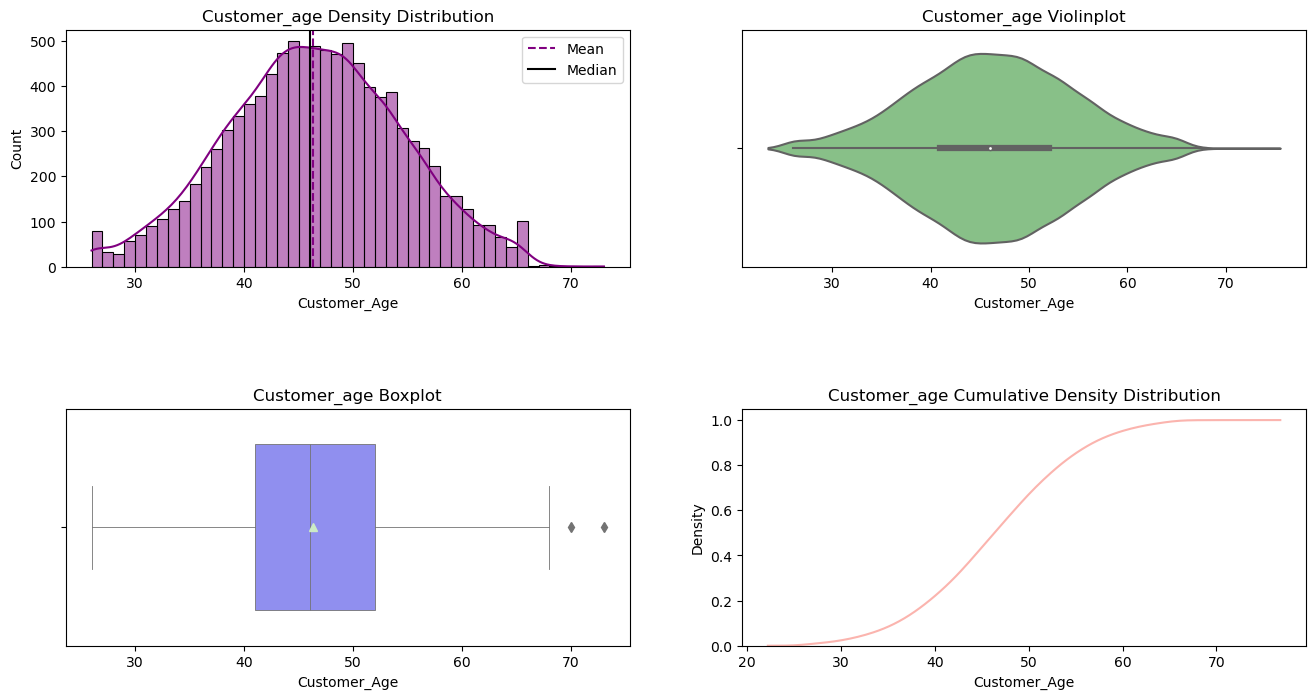

In [10]:
summary(data, "Customer_Age")

5 Point Summary of Dependent_count Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    3 |     5 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


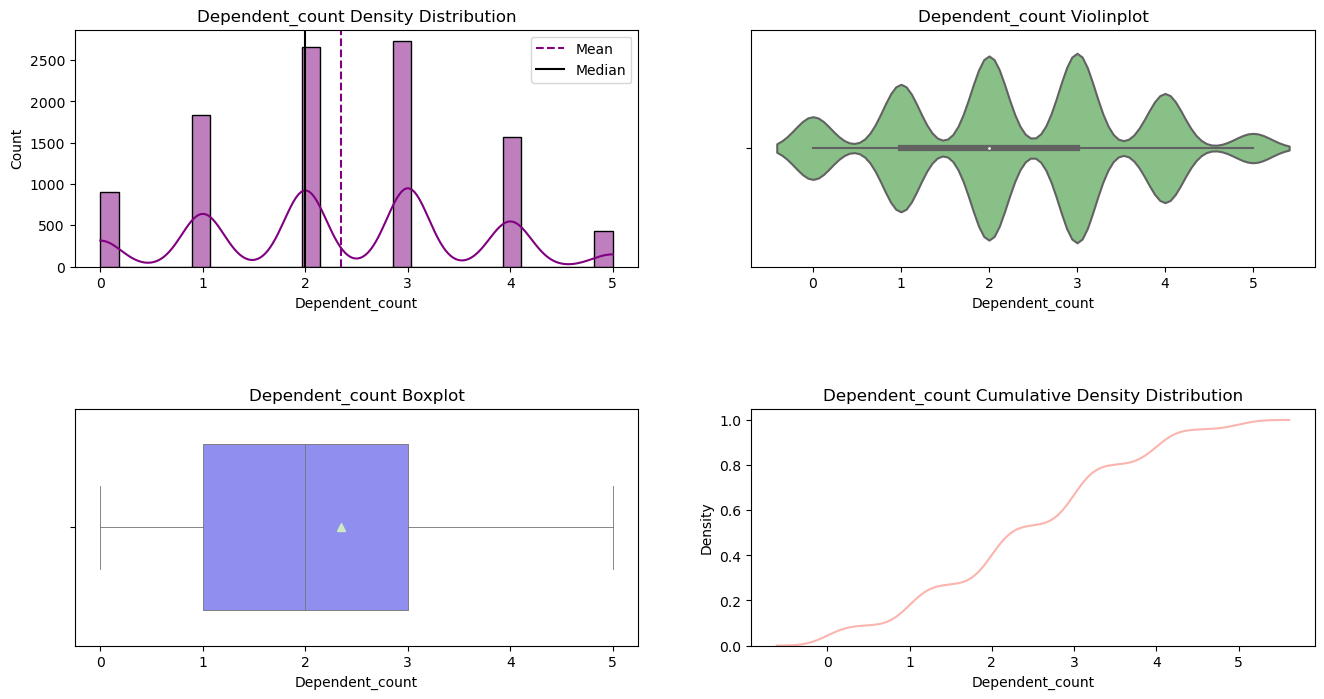

In [11]:
summary(data, "Dependent_count")

5 Point Summary of Months_on_book Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    13 |   31 |   36 |   40 |    56 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


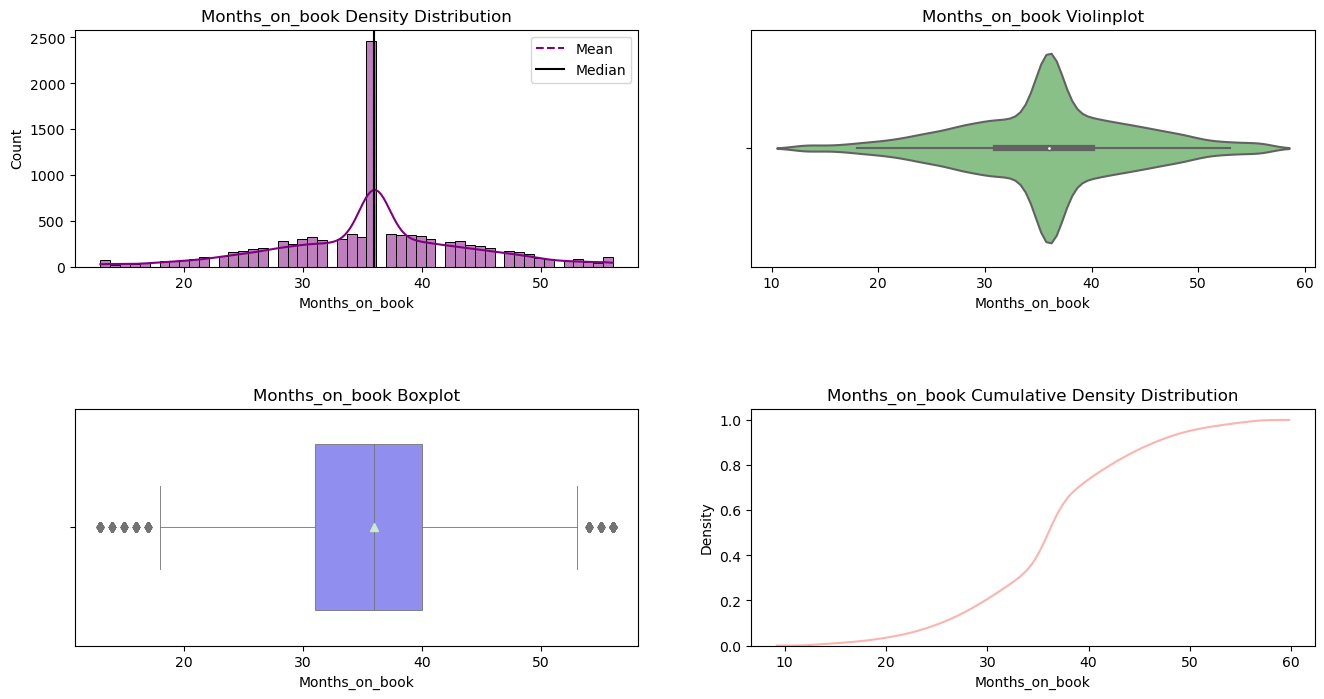

In [12]:
summary(data, "Months_on_book")

5 Point Summary of Months_inactive_12_mon Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    2 |    2 |    3 |     6 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


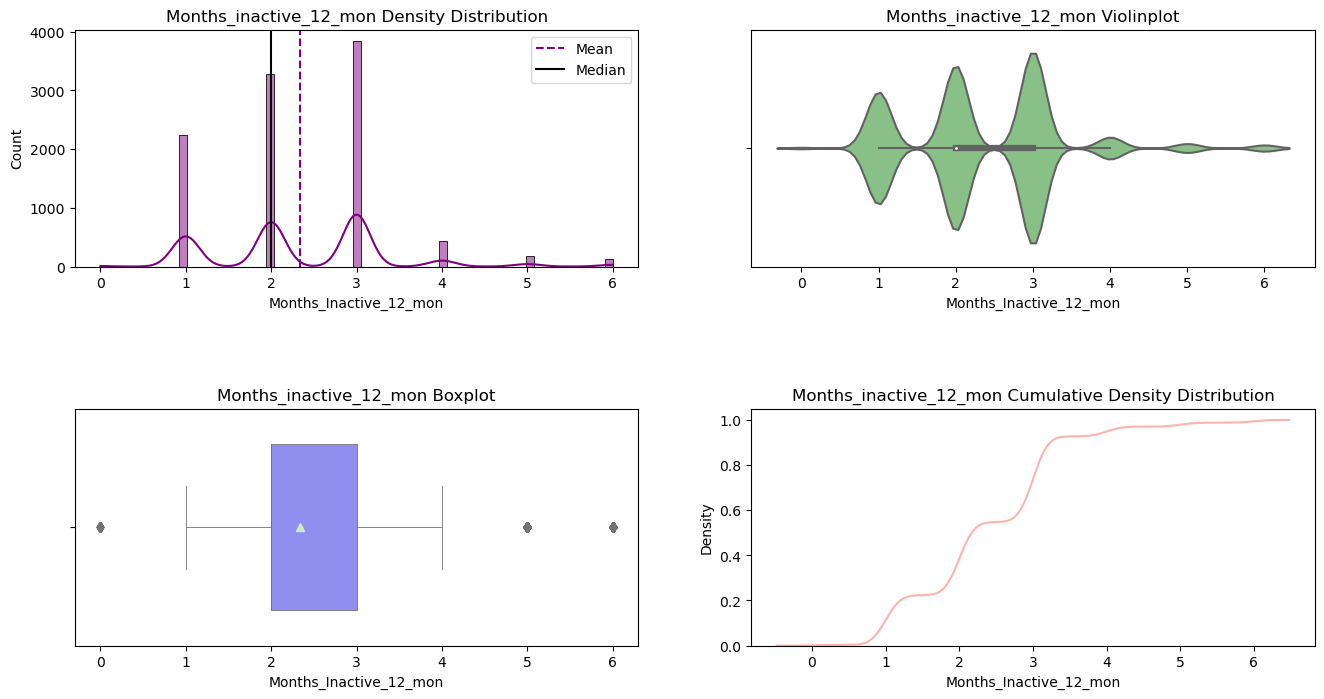

In [13]:
summary(data, "Months_Inactive_12_mon")

5 Point Summary of Credit_limit Attribute:

+-------+--------+------+------+---------+-------+
|       |    Min |   Q1 |   Q2 |      Q3 |   Max |
|-------+--------+------+------+---------+-------|
| Value | 1438.3 | 2555 | 4549 | 11067.5 | 34516 |
+-------+--------+------+------+---------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


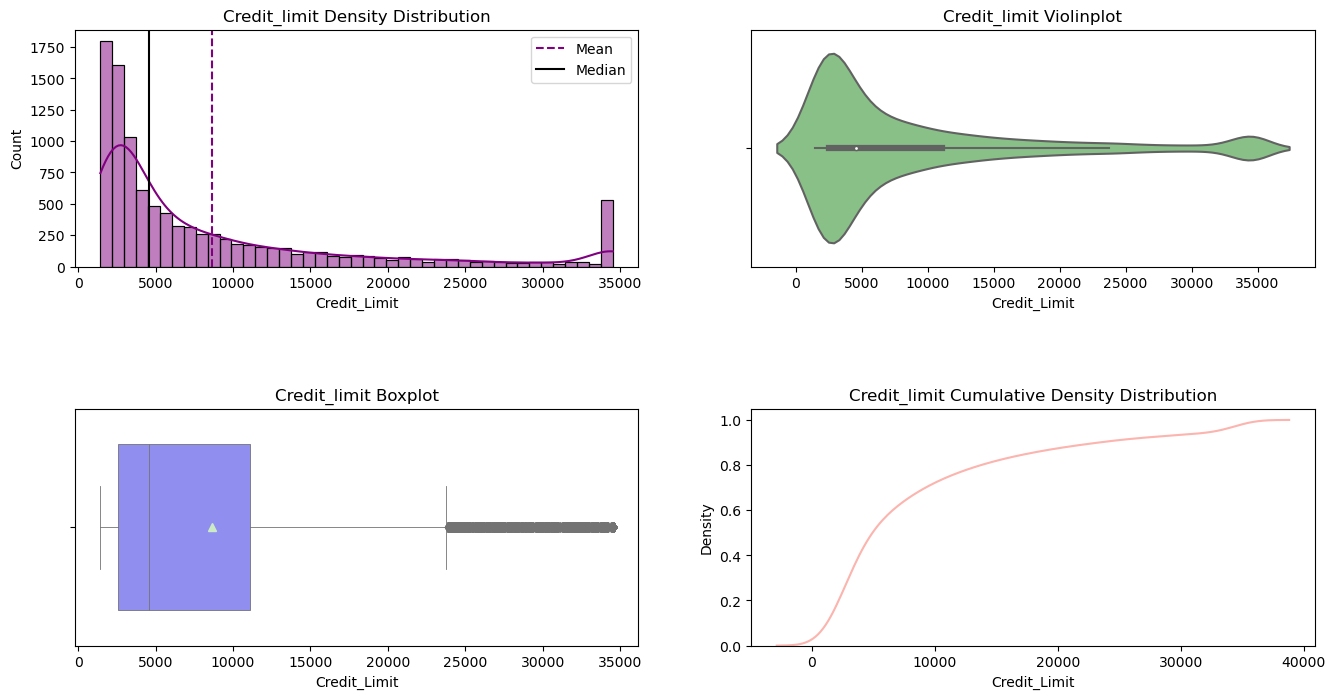

In [14]:
summary(data, "Credit_Limit")

In [15]:
# fig = plt.figure(figsize = (20,20))
# ax = fig.gca()
# plt.tight_layout()
# data.loc[:, ~data.columns.isin(['CLIENTNUM', "Attrition_Flag"])].hist(ax = ax)
# fig.show()

In [16]:
data['Attrition_Flag'] = data.Attrition_Flag.map({'Attrited Customer': 1,
                                               'Existing Customer': 0})
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418,2.594,1887,20,2.333,0
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796,1.405,1171,20,2.333,0.76
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716,2.175,816,28,2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152,0.703,15476,117,0.857,0.462
10123,1,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091,0.804,8764,69,0.683,0.511
10124,1,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409,0.819,10291,60,0.818,0
10125,1,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281,0.535,8395,62,0.722,0


In [17]:
data["Attrition_Flag"].value_counts()

Attrition_Flag
0    8500
1    1627
Name: count, dtype: int64

In [18]:
data['Months_Inactive_12_mon']

0        1
1        1
2        1
3        4
4        1
        ..
10122    2
10123    2
10124    3
10125    3
10126    2
Name: Months_Inactive_12_mon, Length: 10127, dtype: int64

In [19]:
cross_tab = pd.crosstab(index= data['Income_Category'],
                        columns= data ['Attrition_Flag'])

cross_tab_prop = pd.crosstab(index= data ['Income_Category'],
                        columns= data ['Attrition_Flag'],
                             normalize="index")
cross_tab_prop

Attrition_Flag,0,1
Income_Category,,
$120K +,0.826685,0.173315
$40K - $60K,0.848603,0.151397
$60K - $80K,0.865193,0.134807
$80K - $120K,0.842345,0.157655
Less than $40K,0.828138,0.171862
Unknown,0.831835,0.168165


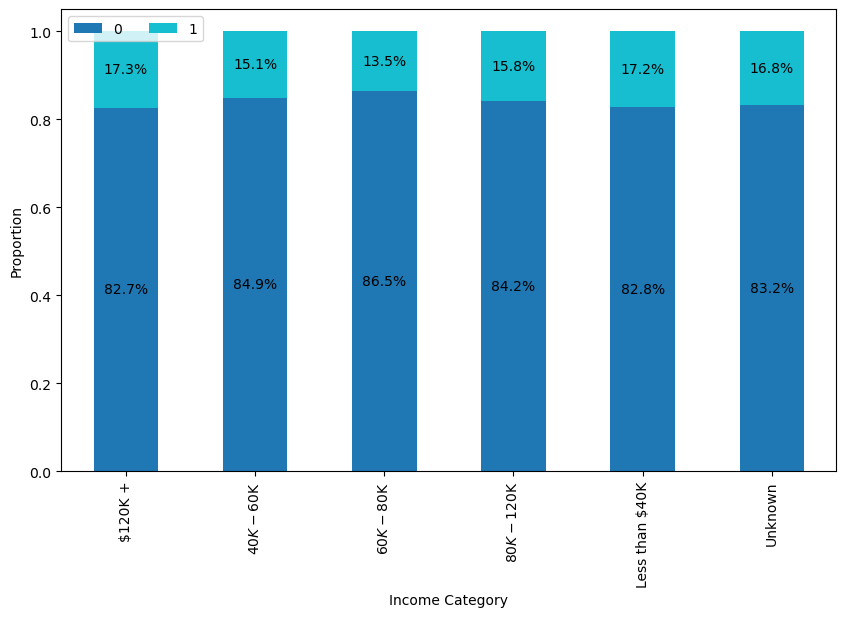

In [20]:
ax = cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Income Category")
plt.ylabel("Proportion")


for c in ax.containers:

    labels = [f'{np.round(v.get_height() * 100, 1)}%' if v.get_height() > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center')

plt.show()

In [21]:
# sns.boxplot(x='Attrition_Flag', y='Months_Inactive_12_mon', data = data)

In [22]:
# sns.boxplot(x='Attrition_Flag', y='Months_on_book', data = data)

Categorical features:
Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category', 'Total_Relationship_Count', 'Contacts_Count_12_mon',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio'],
      dtype='object')
--------------------------------------
Numerical features:
Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Months_Inactive_12_mon', 'Credit_Limit'],
      dtype='object')
--------------------------------------
--------------------------------------
All feature names:
['Customer_Age' 'Dependent_count' 'Months_on_book' ...
 'Avg_Utilization_Ratio_0.994' 'Avg_Utilization_Ratio_0.995'
 'Avg_Utilization_Ratio_0.999']
--------------------------------------
Feature importances:
[1.46605427e-02 9.69403765e-03 1.48365204e-02 ... 2.59606409e-07
 6.69661976e-05 7.20522756e-05]
--------------------------------------
T

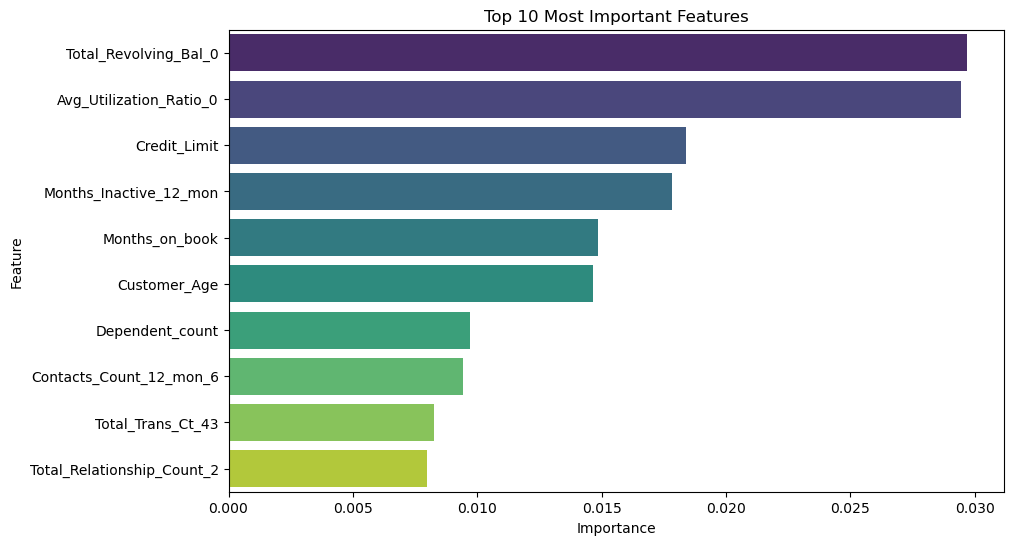

In [23]:
# Feature importances

target = 'Attrition_Flag'
if target not in data.columns:
    raise ValueError(f"Target column '{target}' is not in the dataframe")

X = data.drop(columns=[target])
y = data[target]


categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print("Categorical features:")
print(categorical_features)
print("--------------------------------------")
print("Numerical features:")
print(numerical_features)
print("--------------------------------------")


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


rf_pipeline.fit(X, y)

feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

encoded_feature_names = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, encoded_feature_names])


print("--------------------------------------")
print("All feature names:")
print(all_feature_names)

print("--------------------------------------")

print("Feature importances:")
print(feature_importances)


feature_importances_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

top_10_features = feature_importances_df.head(10)


print("--------------------------------------")
print("Top 10 most important features:")
print(top_10_features)
print("--------------------------------------")

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette="viridis")
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [24]:
top_10_features

,Feature,Importance
41,Total_Revolving_Bal_0,0.029674
15975,Avg_Utilization_Ratio_0,0.029442
4,Credit_Limit,0.018397
3,Months_Inactive_12_mon,0.017816
2,Months_on_book,0.014837
0,Customer_Age,0.014661
1,Dependent_count,0.009694
40,Contacts_Count_12_mon_6,0.009439
15088,Total_Trans_Ct_43,0.008246
29,Total_Relationship_Count_2,0.007993


In [25]:
#Model ----  select top 10 importance columns 
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book',
    'Contacts_Count_12_mon', 'Customer_Age', 'Total_Revolving_Bal', 
    'Dependent_count', 'Total_Trans_Ct', 'Total_Relationship_Count'
]

X = data[selected_columns]

y = data['Attrition_Flag']

# categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94      2543
           1       0.89      0.33      0.49       496

    accuracy                           0.88      3039
   macro avg       0.89      0.66      0.71      3039
weighted avg       0.89      0.88      0.86      3039

Confusion Matrix:
[[2523   20]
 [ 330  166]]


In [26]:
#Model Improvement  ----  select top 5 importance columns 
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book', 'Total_Revolving_Bal'
]

X = data[selected_columns]

y = data['Attrition_Flag']


categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2543
           1       0.45      0.22      0.29       496

    accuracy                           0.83      3039
   macro avg       0.66      0.58      0.60      3039
weighted avg       0.79      0.83      0.80      3039

Confusion Matrix:
[[2413  130]
 [ 389  107]]


In [27]:
#Model Improvement  -----  Class weight adjustment 
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book',
    'Contacts_Count_12_mon', 'Customer_Age', 'Total_Revolving_Bal', 
    'Dependent_count', 'Total_Trans_Ct', 'Total_Relationship_Count'
]

X = data[selected_columns]
y = data['Attrition_Flag']


categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weights = {0: 1, 1: 20} 


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(class_weight= class_weights, random_state=42))])

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2543
           1       0.85      0.38      0.52       496

    accuracy                           0.89      3039
   macro avg       0.87      0.68      0.73      3039
weighted avg       0.88      0.89      0.87      3039

Confusion Matrix:
[[2509   34]
 [ 310  186]]


In [28]:
# confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2509   34]
 [ 310  186]]


In [29]:
#Resample the classes
majority_class = data[data['Attrition_Flag'] == 0]
minority_class = data[data['Attrition_Flag'] == 1]


upsampled_minority = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)


balanced_data = pd.concat([majority_class, upsampled_minority])
balanced_data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418,2.594,1887,20,2.333,0
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796,1.405,1171,20,2.333,0.76
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716,2.175,816,28,2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9211,1,37,M,3,Graduate,Married,$60K - $80K,Blue,28,2,3,2,6407.0,478,5929,1.022,9322,77,0.833,0.075
5857,1,50,M,1,Graduate,Divorced,$120K +,Blue,42,1,3,2,1656.0,0,1656,0.626,2073,44,0.833,0
5886,1,47,F,4,Graduate,Single,Less than $40K,Blue,40,6,4,3,2473.0,0,2473,0.547,2133,44,0.419,0
7550,1,51,M,1,Unknown,Married,$80K - $120K,Blue,39,4,3,4,24462.0,946,23516,0.475,1709,37,0.542,0.039


In [30]:
#Model Improvement  -----  Resample the classes with top 10 Importance columns 
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book',
    'Contacts_Count_12_mon', 'Customer_Age', 'Total_Revolving_Bal', 
    'Dependent_count', 'Total_Trans_Ct', 'Total_Relationship_Count'
]

X = balanced_data[selected_columns]

y = balanced_data['Attrition_Flag']


categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2568
           1       0.96      0.99      0.97      2532

    accuracy                           0.97      5100
   macro avg       0.97      0.97      0.97      5100
weighted avg       0.97      0.97      0.97      5100

Confusion Matrix:
[[2453  115]
 [  25 2507]]


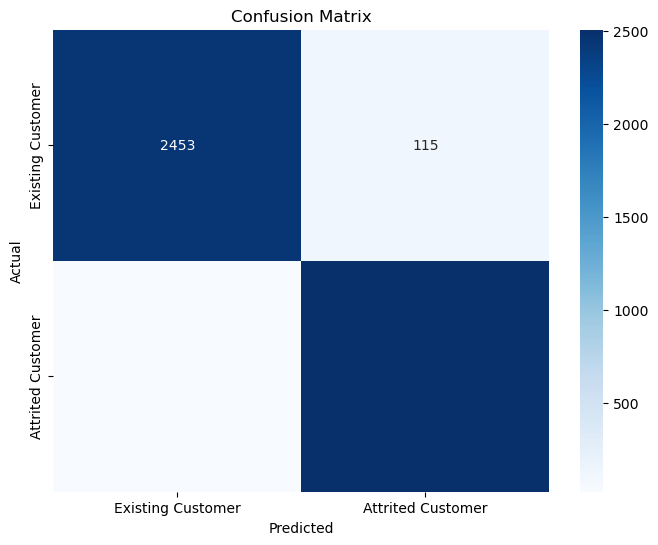

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Existing Customer', 'Attrited Customer'], yticklabels=['Existing Customer', 'Attrited Customer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

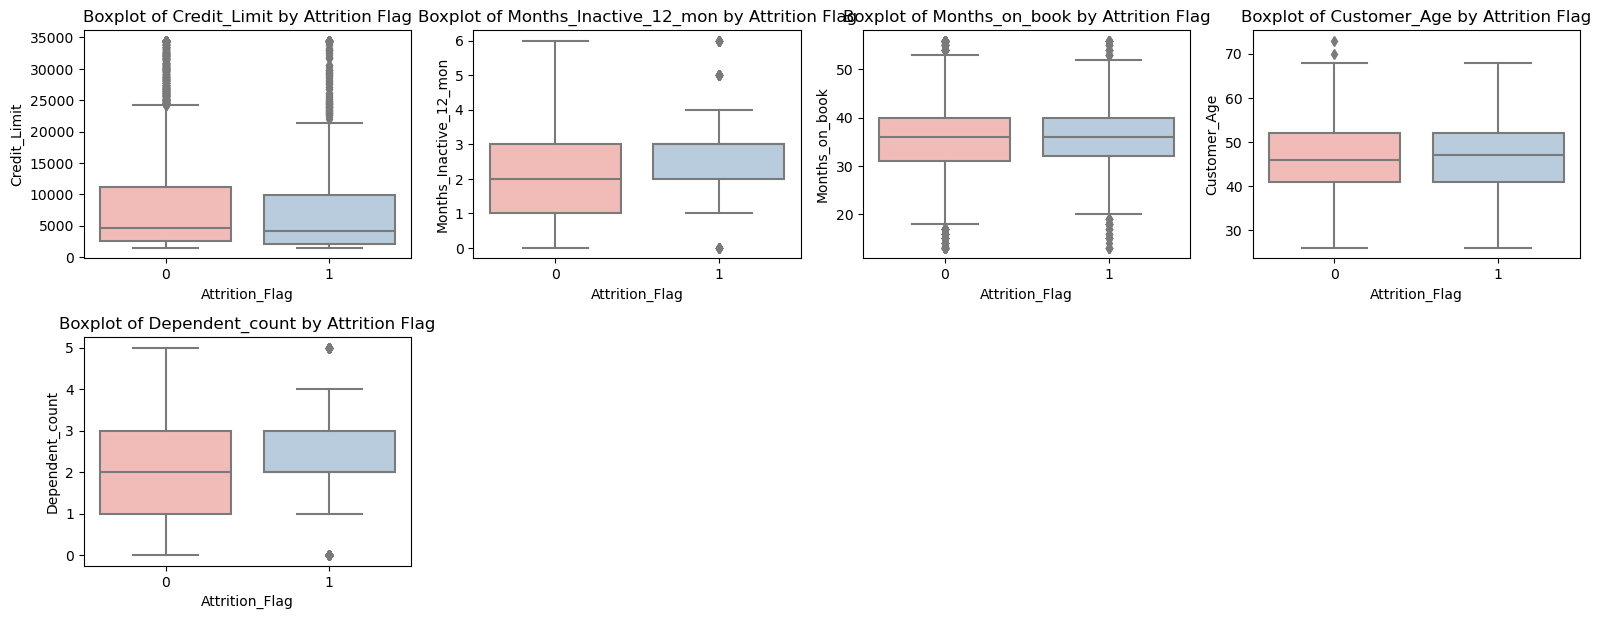

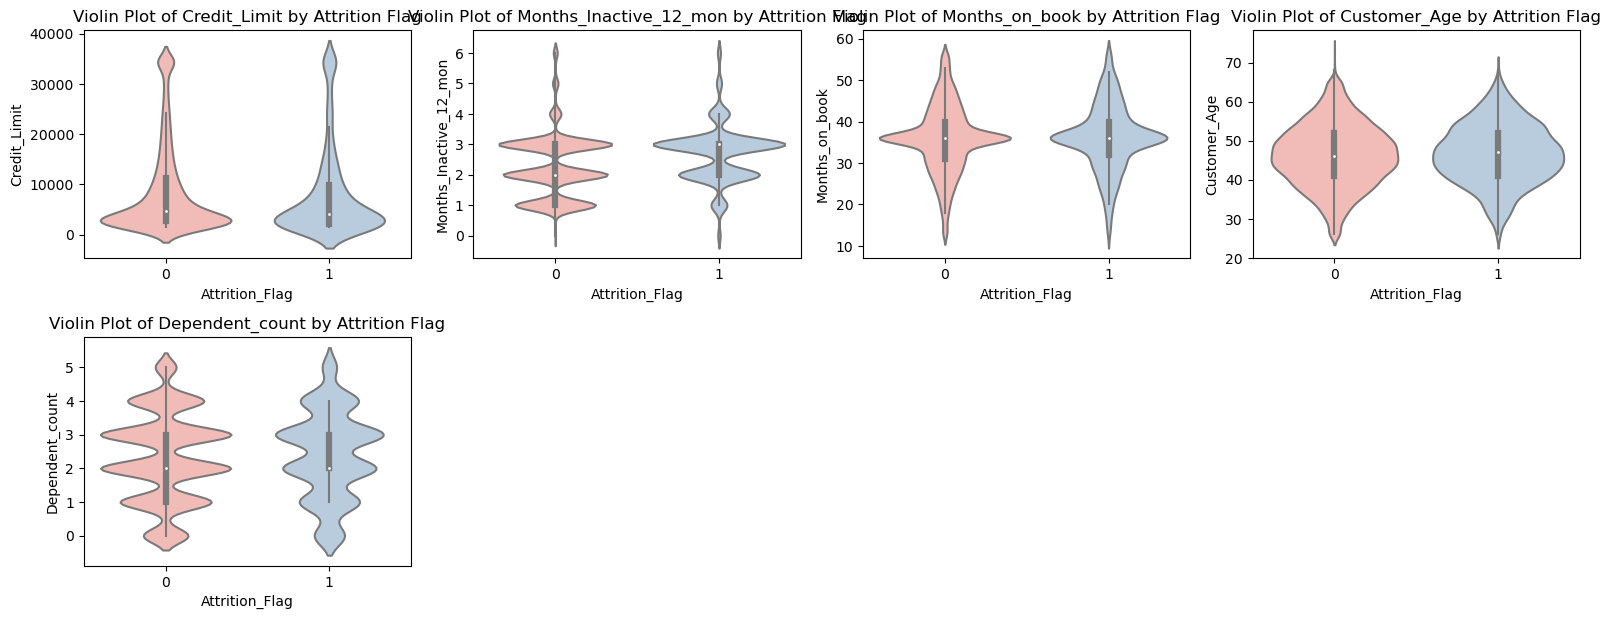

In [32]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='Attrition_Flag', y=col, data=data)
    plt.title(f'Boxplot of {col} by Attrition Flag')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.violinplot(x='Attrition_Flag', y=col, data=data)
    plt.title(f'Violin Plot of {col} by Attrition Flag')
plt.tight_layout()
plt.show()

In [33]:

# Analysis and Conclusion
# Model Performance
# Accuracy: After balancing the samples and select top 10 important columns, the model achieved an accuracy of 0.97. 

# Precision, Recall, and F1-Score:

# For class 0 (Existing Customer):
# Precision: 0.99 - Out of all the instances predicted as 0, 99% were correct.
# Recall: 0.96 - Out of all the actual 0 instances, 96% were correctly identified.
# F1-Score: 0.97 - weighted average of precision and recall that evaluates a model's predictive ability. 0.97 is high accuracy.
# For class 1 (Attrited Customer):
# Precision: 0.96 - Out of all the instances predicted as 1, 96% were correct.
# Recall: 0.99 - Out of all the actual 1 instances, 99% were correctly identified.
# F1-Score: 0.97 - A high value, indicating excellent performance in identifying attrited customers.

# High Recall for Class 1: The recall for class 1 (attrited customers) is 0.99, which is crucial in this context. It means the model is very effective at identifying almost all the customers who are likely to attrite. This is particularly important for retention strategies where missing out on potential attrited customers can be costly.

# Precision and Recall Balance: Both classes have high precision and recall values, resulting in high F1-scores. This balance is desirable as it indicates that the model is both accurate and reliable in its predictions.

# Confusion Matrix Analysis: The confusion matrix shows that there are relatively few misclassifications (140 in total out of 5100 predictions). The majority of errors are false positives (115) rather than false negatives (25), indicating a slight tendency to overpredict attrition, which might be more acceptable than missing actual attrition cases.

# Conclusion
# We were able to imporve Random Forest model, after balancing the classes, performs exceptionally well in predicting customer attrition. The high accuracy, precision, recall, and F1-scores across both classes demonstrate the model's robustness and reliability.

# Recommendations:
# Monitoring and Maintenance: Regularly monitor the model's performance as new data comes in to ensure it continues to perform well.
# Feature Importance Analysis: Investigate the feature importance scores from the Random Forest model to understand which factors are most influential in predicting attrition. This can provide actionable insights for targeted interventions.
# Further Testing: While the model performs well on the balanced dataset, consider additional testing on unseen data or cross-validation to confirm its generalizability.
# Actionable Strategies: Use the insights from the model to develop and implement targeted retention strategies for customers identified as high risk for attrition.
# Overall, the model's high performance metrics suggest it is a valuable tool for predicting and managing customer attrition effectively.